<a href="https://colab.research.google.com/github/MalakAhmed2003/Cellula/blob/main/Cellula_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=2546c484-ce47-4857-a8ab-3ed5504a8771
To: /content/dataset.zip
100%|██████████| 49.1M/49.1M [00:00<00:00, 68.1MB/s]


Top-level folders: ['Teeth_Dataset']
Inside Teeth_Dataset: ['Validation', 'Training', 'Testing']
Detected classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


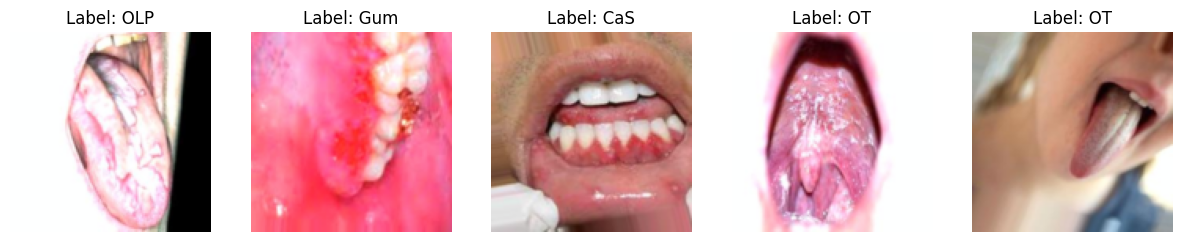

In [1]:
!pip install -q gdown

import gdown
import zipfile
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


file_id = "1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "dataset.zip", quiet=False)

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

print("Top-level folders:", os.listdir("dataset"))
print("Inside Teeth_Dataset:", os.listdir("dataset/Teeth_Dataset"))


# Image transformations (including normalization for pretrained models)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="dataset/Teeth_Dataset/Training", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


print("Detected classes:", dataset.classes)


data_iter = iter(dataloader)
images, labels = next(data_iter)

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i].numpy().transpose((1, 2, 0))

    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    ax[i].imshow(img)
    ax[i].set_title(f"Label: {dataset.classes[labels[i]]}")
    ax[i].axis('off')
plt.show()

In [2]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(dataset.classes))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [4]:
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}, Accuracy: {100 * correct/total:.2f}%")

Epoch 1/5, Loss: 1.0334, Accuracy: 64.30%
Epoch 2/5, Loss: 0.4345, Accuracy: 85.78%
Epoch 3/5, Loss: 0.2485, Accuracy: 91.25%
Epoch 4/5, Loss: 0.2366, Accuracy: 92.00%
Epoch 5/5, Loss: 0.1495, Accuracy: 94.98%


In [5]:
model.eval()
with torch.no_grad():
    img, label = dataset[40]
    img = img.unsqueeze(0).to(device).to(torch.float)
    output = model(img)
    pred = output.argmax(dim=1).item()
    print(f"Predicted class: {dataset.classes[pred]}")


Predicted class: CaS


In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms


model.eval()

# Image transformations (including normalization for pretrained models)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = ImageFolder(root="dataset/Teeth_Dataset/Validation", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

correct = 0
total = 0
val_loss = 0.0


criterion = nn.CrossEntropyLoss()


with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


val_accuracy = 100 * correct / total
avg_loss = val_loss / len(val_loader)

print(f"Validation Loss: {avg_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.3026
Validation Accuracy: 90.18%


In [8]:
from torch.utils.data import DataLoader
import torch

model.eval()

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_correct = 0
test_total = 0
test_loss = 0.0


criterion = nn.CrossEntropyLoss()


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


NameError: name 'test_dataset' is not defined